In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input, BatchNormalization, Reshape, UpSampling2D, PReLU, ReLU
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
from multiprocessing import Pool
import random

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
noise_length=128
width=60
height=60

In [4]:
def G_model(Height, Width, channel=3):
    inputs = Input((noise_length,))
    in_h = int(Height / 4)
    in_w = int(Width / 4)
    x = Dense(in_h * in_w * 128, activation='tanh', name='g_dense1')(inputs)
    x = BatchNormalization()(x)
    x = Reshape((in_h, in_w, 128), input_shape=(128 * in_h * in_w,))(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (5, 5), padding='same', activation='tanh', name='g_conv1')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(channel, (5, 5), padding='same', activation='tanh', name='g_out')(x)
    model = Model(inputs, x, name='G')
    return model

def D_model(Height, Width, channel=3):
    inputs = Input((Height, Width, channel))
    x = Conv2D(64, (5, 5), padding='same',  name='d_conv1', activation="tanh")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (5, 5), padding='same', name='d_conv2', activation="tanh")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu', name='d_dense1')(x)
    x = Dense(1, activation='sigmoid', name='d_out')(x)
    model = Model(inputs, x, name='D')
    return model

In [5]:
def Combined_model(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

In [6]:
g = G_model(Height=height, Width=width, channel=3)
d = D_model(Height=height, Width=width, channel=3)
c = Combined_model(g=g, d=d)

In [7]:
g_opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
d_opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [8]:
g.compile(loss='binary_crossentropy', optimizer='SGD')
d.trainable = False
for layer in d.layers:
    layer.trainable = False
c.compile(loss='binary_crossentropy', optimizer=g_opt)

In [9]:
d.trainable = True
for layer in d.layers:
    layer.trainable = True
d.compile(loss='binary_crossentropy', optimizer=d_opt)

In [10]:
folder="./prepare"

In [11]:
def read_file(filename):
    img=cv2.imread("{0}/{1}".format(folder,filename))
    img=cv2.resize(img,(width,height))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

In [12]:
with Pool() as p:
    imap=p.imap(read_file,os.listdir(folder))
    X=list(tqdm(imap,total=len(os.listdir(folder))))
X_train=np.asarray(X)
X_train=(X_train.astype(np.float32)-127.5)/127.5

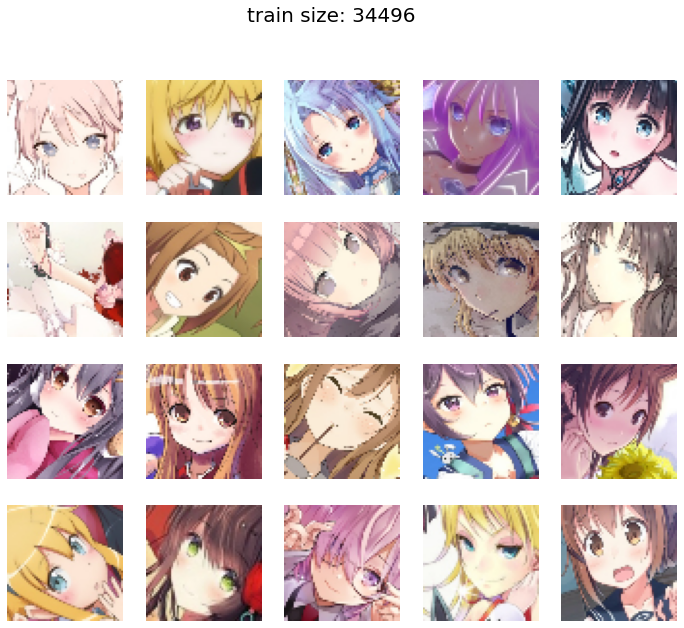

In [13]:
row = 4
col = 5
plt.figure(figsize=(12,10))
plt.suptitle("train size: {0}".format(X_train.shape[0]),fontsize=20)
for i in range(row * col):
    plt.subplot(row, col, i+1)
    plt.imshow((random.choice(X_train)*127.5+127.5).astype(np.uint8))
    plt.axis('off')

In [14]:
def visualize(g,d,epoch=None, row=4, col=5):
    plt.figure(figsize=(col*3,row*3))
    noise = np.random.uniform(-1, 1, size=(row*col, noise_length))
    pred=g.predict(noise, verbose=0)
    losses=d.predict(pred)
    if epoch:
        plt.suptitle("epoch={0}".format(epoch),fontsize=20)
    for i in range(row * col):
        plt.subplot(row, col, i+1)
        plt.imshow((pred[i]*127.5+127.5).astype(np.uint8))
        plt.title(losses[i][0])
        plt.axis('off')
    plt.show()

/usr/local/bin/python/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/bin/python/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



g loss = 0.7639062404632568, d loss = 0.11104756593704224


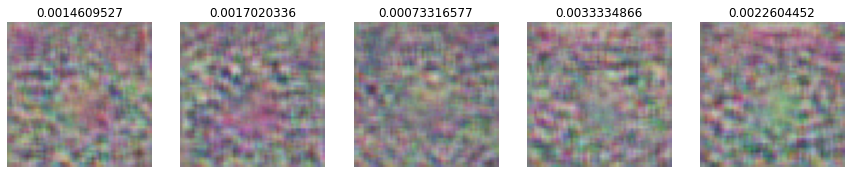


g loss = 4.233740329742432, d loss = 0.37095391750335693


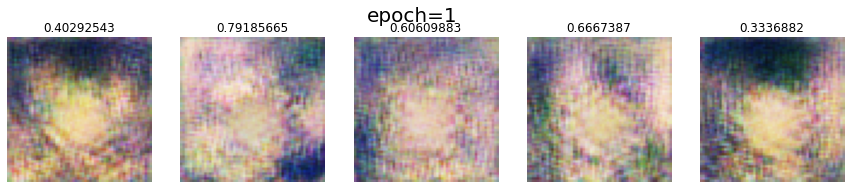


g loss = 1.4859563112258911, d loss = 0.44393062591552734


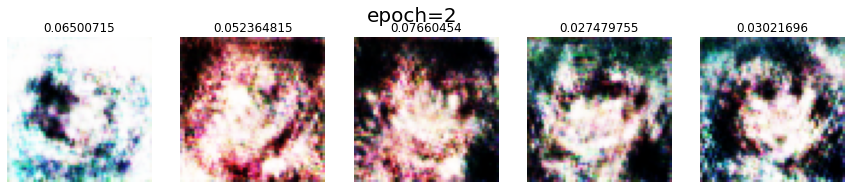


g loss = 2.1894822120666504, d loss = 0.4802130460739136


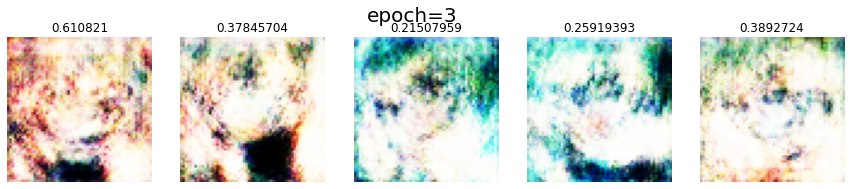

In [ ]:
g_losses=[]
d_losses=[]
epochs=80
batch_size=256
for epoch in tqdm(range(epochs)):
    _g_losses=[]
    _d_losses=[]
    for ite in tqdm(range(X_train.shape[0]//batch_size)):
        #ite += 1
        # Discremenator training
        y = X_train[ite * batch_size: (ite+1) * batch_size]
        input_noise = np.random.uniform(-1, 1, size=(y.shape[0], noise_length))
        g_output = g.predict(input_noise, verbose=0)
        X = np.concatenate((y, g_output))
        Y = [1] * y.shape[0] + [0] * y.shape[0]
        d_loss = d.train_on_batch(X, Y)
        _d_losses.append(d_loss)
        # Generator training
        input_noise = np.random.uniform(-1, 1, size=(batch_size*5, noise_length))
        g_loss = c.train_on_batch(input_noise, [1] * batch_size*5)
        _g_losses.append(g_loss)
    g_losses.append(np.mean(_g_losses))
    d_losses.append(np.mean(_d_losses))
    print("g loss = {0}, d loss = {1}".format(g_losses[-1],d_losses[-1]))
    visualize(g,d,epoch,row=1)

In [ ]:
noise = np.random.uniform(-1, 1, size=(1, noise_length))
plt.imshow((g.predict(noise, verbose=0)[0]*127.5+127.5).astype(np.uint8))

In [ ]:
row = 4
col = 5
plt.figure(figsize=(12,10))
noise = np.random.uniform(-1, 1, size=(row*col, noise_length))
pred=g.predict(noise, verbose=0)
losses=d.predict(pred)
for i in range(row * col):
    plt.subplot(row, col, i+1)
    plt.imshow((pred[i]*127.5+127.5).astype(np.uint8))
    plt.title(losses[i][0])
    plt.axis('off')

In [ ]:
plt.plot(g_losses)

In [ ]:
plt.plot(d_losses)